### Import Packages

In [865]:
import import_ipynb
import matplotlib.pyplot as plt
import numpy as np
import sys
import pickle
from psx import *
from SortingMethods import *
from GraphingMethods import *
from MPA_model import *
plt.rcParams.update({'font.size': 20})
plt.rcParams['figure.figsize'] = (6.5, 8)
plt.rcParams["font.family"] = "Times New Roman"

yfeOUT = pickle.load(open('/Users/carsonconvery/Desktop/LPL Data/y20220412.p','rb'))
IRfirstampOUT = pickle.load(open('/Users/carsonconvery/Desktop/LPL Data/s1in1w20220412.p','rb'))
IR4ampOUT = pickle.load(open('/Users/carsonconvery/Desktop/LPL Data/s42in1w20220412.p','rb'))
GREEN4ampOUT = pickle.load(open('/Users/carsonconvery/Desktop/LPL Data/s42in2w20220412.p','rb'))
GREENsumOUT = pickle.load(open('/Users/carsonconvery/Desktop/LPL Data/s20220412.p','rb'))

### Simulate YFE to 50mm Nd:Glass Amplifier Simulation

In [24]:
def YFEtoFinalSim(input_shape, pulseEnergy, steps):
    
    #Set Pulse Parameters
    SIGNAL_RESOLUTION = steps
    WAVELENGTH = 1053.0e-9 #meters
    PULSE_ENERGY = pulseEnergy
    PULSE_DURATION = 35.0e-9 #seconds
    PULSE_SHAPE = 'interpolate'
    INPUT_AREA = np.pi * (0.8e-3)**2 # in meter square
    
    #Initialize 
    PAD_ZERO = False # pad zero before and after the pulse. If true, the length of signal array will be twice of SIGNAL_RESOLUTION
    FWHM = 2.0e-9 # full width at half maximum
    xpoints = np.array([0.25*ii for ii in range(SIGNAL_RESOLUTION)])
    ypoints = input_shape
    kind = 'quadratic' # kind of interpolation
    signal_generator = SignalGenerator(SIGNAL_RESOLUTION)
    peak_power = signal_generator.calculate_peak_power(PULSE_DURATION, PULSE_ENERGY, PULSE_SHAPE, FWHM = FWHM, xpoints = xpoints, ypoints = ypoints, kind = kind, pad_zero = PAD_ZERO)
    initial_time, initial_power_t = signal_generator.generate_signal(PULSE_DURATION, peak_power, PULSE_SHAPE, FWHM = FWHM, xpoints = xpoints, ypoints = ypoints, kind = kind, pad_zero = PAD_ZERO)
    dt = initial_time[1] - initial_time[0]
    initial_amp_t = np.sqrt(np.abs(np.around(initial_power_t,decimals=15))) # convert to amplitude
    initial_signal_pile = pack_signal_pile([WAVELENGTH], [initial_amp_t], INPUT_AREA, dt)
    
    # BACK-END
    PUMP4_AREA = np.pi * (4.5e-3)**2 # in meter square
    
    # CRYSTAL 1 parameters
    CRYSTAL1_ALPHA = np.infty # attenuation in 
    CRYSTAL1_QD = 1 # quantum defect
    CRYSTAL1_LENGTH = 40.0e-2 # length in meter
    CRYSTAL1_N2 = 0 # nonlinear refractive index in m^2/W
    CRYSTAL1_J_SAT = 5.0e4 # saturation fluence in J/m^2
    
    # initiate crystal 1 object
    crystal1 = Crystal(CRYSTAL1_ALPHA, CRYSTAL1_QD, CRYSTAL1_LENGTH, CRYSTAL1_N2, CRYSTAL1_J_SAT)
    
    # pump energy parameters
    PUMP1_ENERGY = 44.26 # in joule
    PUMP1_AREA =  np.pi * (8.0e-3)**2 # in meter square
    PUMP1_ENERGY_DISTRIBUTION = 'uniform'
    PUMP1_FRONT_PUMP = True
    PUMP1_BACK_PUMP = False
    
    # initiate pump 1 object
    pump1 = Pump(PUMP1_ENERGY, PUMP1_AREA)
    
    # multipass amplifier (MPA) 1 parameters
    MPA1_CRYSTAL_RESOLUTION = 10 # number of crystal splits
    MPA1_NUMPASS = 1 # number of passes
    MPA1_LOSS_PER_PATH = 0 # percent of energy loss per path
    
    #initiate MPA 1 
    m1 = MultiPassAmplifier(crystal1)
    m1.set_crystal_res(MPA1_CRYSTAL_RESOLUTION)
    m1.set_loss_per_path(MPA1_LOSS_PER_PATH)
    m1.clear_passes()
    
    # calculate stored energy 
    store1 = m1.calculate_stored_energy_from_pump(pump1, PUMP1_ENERGY_DISTRIBUTION, front_pump = PUMP1_FRONT_PUMP, back_pump = PUMP1_BACK_PUMP)
    
    # changing the seed area from the 10mm to 25mm
    AREA_MULTIPLIER = PUMP1_AREA/PUMP4_AREA
    signal_manip = SignalManipulator()
    after_resize3 = signal_manip.manipulate_signal_pile(initial_signal_pile, 1, 0, AREA_MULTIPLIER, 0)
    
    # amplify the signal
    m1.calculate_multi_pass_amplification(store1, after_resize3, MPA1_NUMPASS)
    after_crystal5_signal_pile = m1.get_single_pass_output()

    # SPLIT parameters
    NUM_SPLIT = 4
    ENERGY_MULTIPLIER = 1/NUM_SPLIT
    AREA_MULTIPLIER = 4.25
    
    # initiate signal manipulator
    signal_manip = SignalManipulator()
    after_split_signal_pile = signal_manip.manipulate_signal_pile(after_crystal5_signal_pile, ENERGY_MULTIPLIER, 0, AREA_MULTIPLIER, 0)
    
    
    
    # CRYSTAL 2 parameters
    CRYSTAL2_ALPHA = np.infty # attenuation in 
    CRYSTAL2_QD = 1 # quantum defect
    CRYSTAL2_LENGTH = 15e-3 # length in meter
    CRYSTAL2_N2 = 0 # nonlinear refractive index in 1/W^2
    CRYSTAL2_J_SAT = 5.0e4 # saturation fluence
    
    # initiate crystal 2 object
    crystal2 = Crystal(CRYSTAL2_ALPHA, CRYSTAL2_QD, CRYSTAL2_LENGTH, CRYSTAL2_N2, CRYSTAL2_J_SAT)
    
    # pump energy parameters
    PUMP2_ENERGY = 130 #in joule
    PUMP2_AREA = np.pi * (16e-3)**2 #in meter square
    PUMP2_ENERGY_DISTRIBUTION = 'uniform'
    PUMP2_FRONT_PUMP = True
    PUMP2_BACK_PUMP = False
    
    # initiate pump 1 object
    pump2 = Pump(PUMP2_ENERGY, PUMP2_AREA)
    
    # multipass amplifier (MPA) 2 parameters
    MPA2_CRYSTAL_RESOLUTION = 10 # number of crystal splits
    MPA2_NUMPASS = 1 # number of passes
    MPA2_LOSS_PER_PATH = 0 # percent of energy loss per path
    
    # initiate MPA 2
    m2 = MultiPassAmplifier(crystal2)
    m2.set_crystal_res(MPA2_CRYSTAL_RESOLUTION)
    m2.set_loss_per_path(MPA2_LOSS_PER_PATH)
    m2.clear_passes()
    
    # calculate stored energy 
    store2 = m2.calculate_stored_energy_from_pump(pump2, PUMP2_ENERGY_DISTRIBUTION, front_pump = PUMP2_FRONT_PUMP, back_pump = PUMP2_BACK_PUMP)
    
    # amplify the signal
    m2.calculate_multi_pass_amplification(store2, after_split_signal_pile, MPA2_NUMPASS)
    after_crystal6_signal_pile = m2.get_single_pass_output()
    #print(m2.get_total_energy_signal_pile(after_crystal6_signal_pile))
    
    # RECOMBINING
    NUM_RECOMBINE = 4
    after_recombine_signal_pile = signal_manip.multiply_energy_signal_pile(after_crystal6_signal_pile, NUM_RECOMBINE)
    
    # unpack signal pile back to time series
    after_recombine_amp_t = unpack_signal_pile(after_recombine_signal_pile, dt)[0]
    after_recombine_power_t = np.absolute(after_recombine_amp_t) **2
    
    return after_recombine_power_t

### 25mm Amplifier Simulation

In [58]:
def FirstAmp(input_shape, pulseEnergy, steps):
    
    #Set Pulse Parameters
    SIGNAL_RESOLUTION = steps
    WAVELENGTH = 1053.0e-9 #meters
    PULSE_ENERGY = pulseEnergy
    PULSE_DURATION = 35.0e-9 #seconds
    PULSE_SHAPE = 'interpolate'
    INPUT_AREA = np.pi * (0.8e-3)**2 # in meter square
    
    #Initialize 
    PAD_ZERO = False # pad zero before and after the pulse. If true, the length of signal array will be twice of SIGNAL_RESOLUTION
    FWHM = 2.0e-9 # full width at half maximum
    xpoints = np.array([0.25*ii for ii in range(SIGNAL_RESOLUTION)])
    ypoints = input_shape
    kind = 'quadratic' # kind of interpolation
    signal_generator = SignalGenerator(SIGNAL_RESOLUTION)
    peak_power = signal_generator.calculate_peak_power(PULSE_DURATION, PULSE_ENERGY, PULSE_SHAPE, FWHM = FWHM, xpoints = xpoints, ypoints = ypoints, kind = kind, pad_zero = PAD_ZERO)
    initial_time, initial_power_t = signal_generator.generate_signal(PULSE_DURATION, peak_power, PULSE_SHAPE, FWHM = FWHM, xpoints = xpoints, ypoints = ypoints, kind = kind, pad_zero = PAD_ZERO)
    dt = initial_time[1] - initial_time[0]
    initial_amp_t = np.sqrt(np.abs(np.around(initial_power_t,decimals=15))) # convert to amplitude
    initial_signal_pile = pack_signal_pile([WAVELENGTH], [initial_amp_t], INPUT_AREA, dt)
    
    # BACK-END
    PUMP4_AREA = np.pi * (4.5e-3)**2 # in meter square
    
    # CRYSTAL 1 parameters
    CRYSTAL1_ALPHA = np.infty # attenuation in 
    CRYSTAL1_QD = 1 # quantum defect
    CRYSTAL1_LENGTH = 40.0e-2 # length in meter
    CRYSTAL1_N2 = 0 # nonlinear refractive index in m^2/W
    CRYSTAL1_J_SAT = 5.0e4 # saturation fluence in J/m^2
    
    # initiate crystal 1 object
    crystal1 = Crystal(CRYSTAL1_ALPHA, CRYSTAL1_QD, CRYSTAL1_LENGTH, CRYSTAL1_N2, CRYSTAL1_J_SAT)
    
    # pump energy parameters
    PUMP1_ENERGY = 44.26 # in joule
    PUMP1_AREA =  np.pi * (8.0e-3)**2 # in meter square
    PUMP1_ENERGY_DISTRIBUTION = 'uniform'
    PUMP1_FRONT_PUMP = True
    PUMP1_BACK_PUMP = False
    
    # initiate pump 1 object
    pump1 = Pump(PUMP1_ENERGY, PUMP1_AREA)
    
    # multipass amplifier (MPA) 1 parameters
    MPA1_CRYSTAL_RESOLUTION = 10 # number of crystal splits
    MPA1_NUMPASS = 1 # number of passes
    MPA1_LOSS_PER_PATH = 0 # percent of energy loss per path
    
    #initiate MPA 1 
    m1 = MultiPassAmplifier(crystal1)
    m1.set_crystal_res(MPA1_CRYSTAL_RESOLUTION)
    m1.set_loss_per_path(MPA1_LOSS_PER_PATH)
    m1.clear_passes()
    
    # calculate stored energy 
    store1 = m1.calculate_stored_energy_from_pump(pump1, PUMP1_ENERGY_DISTRIBUTION, front_pump = PUMP1_FRONT_PUMP, back_pump = PUMP1_BACK_PUMP)
    
    # changing the seed area from the 10mm to 25mm
    AREA_MULTIPLIER = PUMP1_AREA/PUMP4_AREA
    signal_manip = SignalManipulator()
    after_resize3 = signal_manip.manipulate_signal_pile(initial_signal_pile, 1, 0, AREA_MULTIPLIER, 0)
    
    # amplify the signal
    m1.calculate_multi_pass_amplification(store1, after_resize3, MPA1_NUMPASS)
    after_crystal5_signal_pile = m1.get_single_pass_output()

    # SPLIT parameters
    NUM_SPLIT = 1
    ENERGY_MULTIPLIER = 1/NUM_SPLIT
    AREA_MULTIPLIER = 4.25
    
    # initiate signal manipulator
    signal_manip = SignalManipulator()
    after_split_signal_pile = signal_manip.manipulate_signal_pile(after_crystal5_signal_pile, ENERGY_MULTIPLIER, 0, AREA_MULTIPLIER, 0)
    
    # RECOMBINING
    NUM_RECOMBINE = 1
    after_recombine_signal_pile = signal_manip.multiply_energy_signal_pile(after_crystal5_signal_pile, NUM_RECOMBINE)
    
    # unpack signal pile back to time series
    after_recombine_amp_t = unpack_signal_pile(after_recombine_signal_pile, dt)[0]
    after_recombine_power_t = np.absolute(after_recombine_amp_t) **2
    
    #calculate signal energy
    pulse_energy = np.trapz(after_recombine_power_t, dx = dt)
    
    return after_recombine_power_t, after_crystal5_signal_pile, pulse_energy

### 50mm Amplifier Simulation

In [548]:
#Set Pulse Parameters
def SecondAmp(input_shape, signal_pile, pulseEnergy, steps):
    SIGNAL_RESOLUTION = steps
    WAVELENGTH = 1053.0e-9 #meters
    PULSE_ENERGY = pulseEnergy
    PULSE_DURATION = 35.0e-9 #seconds
    PULSE_SHAPE = 'interpolate'
    INPUT_AREA = np.pi * (0.8e-3)**2 # in meter square
    
    #Initialize 
    PAD_ZERO = False # pad zero before and after the pulse. If true, the length of signal array will be twice of SIGNAL_RESOLUTION
    FWHM = 2.0e-9 # full width at half maximum
    xpoints = np.array([0.25*ii for ii in range(SIGNAL_RESOLUTION)])
    ypoints = input_shape
    kind = 'quadratic' # kind of interpolation
    signal_generator = SignalGenerator(SIGNAL_RESOLUTION)
    peak_power = signal_generator.calculate_peak_power(PULSE_DURATION, PULSE_ENERGY, PULSE_SHAPE, FWHM = FWHM, xpoints = xpoints, ypoints = ypoints, kind = kind, pad_zero = PAD_ZERO)
    initial_time, initial_power_t = signal_generator.generate_signal(PULSE_DURATION, peak_power, PULSE_SHAPE, FWHM = FWHM, xpoints = xpoints, ypoints = ypoints, kind = kind, pad_zero = PAD_ZERO)
    dt = initial_time[1] - initial_time[0]
    initial_amp_t = np.sqrt(np.abs(np.around(initial_power_t,decimals=15))) # convert to amplitude
    initial_signal_pile = pack_signal_pile([WAVELENGTH], [initial_amp_t], INPUT_AREA, dt)
    
    NUM_SPLIT = 4
    ENERGY_MULTIPLIER = 1/NUM_SPLIT
    PUMP1_AREA = np.pi * (8.0e-3)**2
    PUMP2_AREA = np.pi * (16e-3)**2
    AREA_MULTIPLIER = 4.25
    
    signal_manip = SignalManipulator()
    after_split_signal_pile = signal_manip.manipulate_signal_pile(signal_pile, ENERGY_MULTIPLIER, 0, AREA_MULTIPLIER, 0)
    
    # CRYSTAL 2 parameters
    CRYSTAL2_ALPHA = np.infty # attenuation in 
    CRYSTAL2_QD = 1 # quantum defect
    CRYSTAL2_LENGTH = 15e-3 # length in meter
    CRYSTAL2_N2 = 0 # nonlinear refractive index in 1/W^2
    CRYSTAL2_J_SAT = 5.0e4 # saturation fluence
    
    # initiate crystal 2 object
    crystal2 = Crystal(CRYSTAL2_ALPHA, CRYSTAL2_QD, CRYSTAL2_LENGTH, CRYSTAL2_N2, CRYSTAL2_J_SAT)
    
    # pump energy parameters
    PUMP2_ENERGY = 130 #in joule
    PUMP2_AREA = np.pi * (16e-3)**2 #in meter square
    PUMP2_ENERGY_DISTRIBUTION = 'uniform'
    PUMP2_FRONT_PUMP = True
    PUMP2_BACK_PUMP = False
    
    # initiate pump 1 object
    pump2 = Pump(PUMP2_ENERGY, PUMP2_AREA)
    
    # multipass amplifier (MPA) 2 parameters
    MPA2_CRYSTAL_RESOLUTION = 10 # number of crystal splits
    MPA2_NUMPASS = 1 # number of passes
    MPA2_LOSS_PER_PATH = 0 # percent of energy loss per path
    
    # initiate MPA 2
    m2 = MultiPassAmplifier(crystal2)
    m2.set_crystal_res(MPA2_CRYSTAL_RESOLUTION)
    m2.set_loss_per_path(MPA2_LOSS_PER_PATH)
    m2.clear_passes()
    
    # calculate stored energy 
    store2 = m2.calculate_stored_energy_from_pump(pump2, PUMP2_ENERGY_DISTRIBUTION, front_pump = PUMP2_FRONT_PUMP, back_pump = PUMP2_BACK_PUMP)
    
    # amplify the signal
    m2.calculate_multi_pass_amplification(store2, after_split_signal_pile, MPA2_NUMPASS)
    after_crystal6_signal_pile = m2.get_single_pass_output()
    #print(m2.get_total_energy_signal_pile(after_crystal6_signal_pile))
    
    # RECOMBINING
    NUM_RECOMBINE = 4
    after_recombine_signal_pile = signal_manip.multiply_energy_signal_pile(after_crystal6_signal_pile, NUM_RECOMBINE)
    
    # unpack signal pile back to time series
    after_recombine_amp_t = unpack_signal_pile(after_recombine_signal_pile, dt)[0]
    after_recombine_power_t = np.absolute(after_recombine_amp_t) **2
    
    # calculating pulse energy
    pulse_energy = np.trapz(after_recombine_power_t, dx = dt)
    
    return after_recombine_power_t, pulse_energy

### Create Impulse Response and Transfer Functions

In [358]:
def createIRAndTF(totalSteps, paramArr): #[alpha, beta, delta]
    totalTime = 50e-9
    sampleSpacing = totalTime/totalSteps
    
    alpha = paramArr[0]
    beta = paramArr[1]
    delta = paramArr[2]
    gamma = paramArr[3]
    
    xAxis = np.linspace(0, totalTime, totalSteps)
    
    def impulseResponse(x, alpha, beta, delta, gamma):
        value = (((alpha*x)+beta)**(-delta)-gamma)
        return value
    
    IR = np.zeros(0)
    for x in range (totalSteps):
        value = impulseResponse(xAxis[x], alpha, beta, delta, gamma)
        if value >= 0:
            IR = np.append(IR, value)
        else:
            IR = np.append(IR, [0])
    
    normConstant = 1/np.sum(IR)
    normIR = normConstant*IR
    
    freqBin = np.fft.fftfreq(totalSteps, sampleSpacing)
    idx1 = np.argsort(freqBin)
    freqBin = freqBin[idx1]
    
    TF = np.fft.fft(normIR)
    TF = TF[idx1]
    
    return xAxis, normIR, freqBin, TF

### Deconvolve YFE and Final Waveform

In [91]:
def deconvolve(data, tf, lowPassFreq):
    totalSteps = len(data)
    totalTime = 50e-9
    sampleSpacing = totalTime/totalSteps
    
    freqBin = np.fft.fftfreq(totalSteps, sampleSpacing)
    idx1 = np.argsort(freqBin)
    freqBin = freqBin[idx1]
    
    fftData = np.fft.fft(data)
    fftData = fftData[idx1]
    
    filt = 1/tf
    for x in range (len(filt)):
        if np.abs(freqBin[x])>lowPassFreq:
            filt[x] = 0
    
    deconvFFT = fftData*filt
    
    deconv = np.abs(np.fft.ifft(deconvFFT))
    
    deconvSum = np.sum(deconv)
    dataSum = np.sum(data)
    
    normalFactor = dataSum/deconvSum
    
    deconv = normalFactor * deconv
    
    return deconv

#Deconvolve data before running through amplification simulation

### Prepare Data

In [693]:
def prepareAmpData(data, deconv_data, start_time, stop_time):
    total_time = 50e-9
    total_steps = len(data)
    x_axis = np.linspace(0, total_time, total_steps)
    
    start_index = int((start_time/total_time)*total_steps)
    stop_index = int((stop_time/total_time)*total_steps)
    
    x_axis_spliced = np.copy(x_axis)
    x_axis_spliced = x_axis_spliced[0:stop_index-start_index] * 1e9 #to ns
    
    data_spliced = np.copy(data)
    data_spliced = data_spliced[start_index:stop_index]
    
    deconv_data_spliced = np.copy(deconv_data)
    deconv_data_spliced = deconv_data_spliced[start_index:stop_index]
    
    #norm_const = np.sum(data_spliced)/np.sum(deconv_data_spliced)
    
    #deconv_data_spliced = norm_const * deconv_data_spliced
    
    return x_axis_spliced, data_spliced, deconv_data_spliced

### Plot Simulation vs Real Data With Filter

In [1000]:
def plotSimAndRealDeconvolved(x_axis, real_data, sim_data, xLim = False, yLim = False):
    df1 = plt.figure()
    
    real_data = real_data/(np.sum(real_data))
    sim_data = sim_data/(np.sum(sim_data))
    
    if max(real_data)>max(sim_data):
        norm_const = 1/max(real_data)
    else:
        norm_const = 1/max(sim_data)
        
    real_data = norm_const * real_data
    sim_data = norm_const * sim_data
    
    plt.plot(x_axis, real_data, '--', color = "black", label = "Measured", linewidth = 2)
    plt.plot(x_axis, sim_data, color = "black", label = "Simulated", linewidth = 4)
    
    if xLim:
        plt.xlim(xLim)
    
    if yLim:
        plt.ylim(yLim)
        
    plt.fill_between(x_axis, real_data, sim_data, label = "Error", color = "red", alpha = .5)
    
    plt.ylabel("Normalized Power", fontsize = 22)
    
    plt.xlabel("Time (ns)", fontsize = 22)
    
    plt.title("Post-Amplification", fontsize = 32)
    
    #error = int(0)
    #for x in range (len(x_axis)):
        #addError = np.abs(real_data[x]-sim_data[x])
        #error = error + addError
    
    #percError = (error/np.sum(sim_data))*100
    
    error = int(0)
    for x in range (len(x_axis)):
        addError = (real_data[x]-sim_data[x])**2
        error = error + addError
    
    error = (error/(len(x_axis)))**.5
    
    print("Error:", error)
    
    df1 = plt.show()
    return

### Plot Simulation vs Real Data Without Filter

In [1001]:
def plotSimAndRealConvolved(x_axis, real_data, sim_data, xLim = False, yLim = False):
    df2 = plt.figure()
    
    real_data = real_data/(np.sum(real_data))
    sim_data = sim_data/(np.sum(sim_data))
    
    if max(real_data)>max(sim_data):
        norm_const = 1/max(real_data)
    else:
        norm_const = 1/max(sim_data)
        
    real_data = norm_const * real_data
    sim_data = norm_const * sim_data
    
    plt.plot(x_axis, real_data, '--', color = "black", label = "Measured", linewidth = 2)
    plt.plot(x_axis, sim_data, color = "black", label = "Simulated", linewidth = 3.5)
    
    print(np.sum(real_data))
    print(np.sum(sim_data))
    
    if xLim:
        plt.xlim(xLim)
    
    if yLim:
        plt.ylim(yLim)
        
    plt.fill_between(x_axis, real_data, sim_data, label = "Error", color = "red", alpha = .5)
    
    plt.ylabel("Normalized Power", fontsize = 22)
    
    plt.xlabel("Time (ns)", fontsize = 22)
    
    plt.title("Post-Amplification", fontsize = 32)
    
    #error = int(0)
    #for x in range (len(x_axis)):
        #addError = np.abs(real_data[x]-sim_data[x])
        #error = error + addError
    
    #percError = (error/np.sum(sim_data))*100
    
    error = int(0)
    for x in range (len(x_axis)):
        addError = (real_data[x]-sim_data[x])**2
        error = error + addError
    
    error = (error/(len(x_axis)))**.5
    
    print("Error:", error)
    
    df2.show()
    return

### Running Functions 1

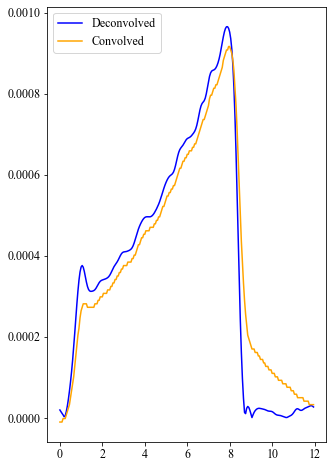

In [813]:
#Deconvolving YFE Signal and Testing Splicing Function
dayData = ConcatenateDayData(yfeOUT, IRfirstampOUT, IR4ampOUT, GREEN4ampOUT, GREENsumOUT)
tensor = SortDayData(dayData)
yfe = tensor[6][0][0][1]

deconv_YFE_Arr = [200000000000, 7.4, 1.27, 0]
total_steps = len(yfe)
x_axis, IR, freq_bin, TF = createIRAndTF(total_steps, deconv_YFE_Arr)

deconv_yfe = deconvolve(yfe, TF, 3e9)

start_time = 4.5e-9
stop_time = 16.5e-9

x_axis_spliced, yfe_spliced, deconv_yfe_spliced = prepareAmpData(yfe, deconv_yfe, start_time, stop_time)

#plt.plot(xAxis, IR)
plt.plot(x_axis_spliced, deconv_yfe_spliced, color = "blue", label = "Deconvolved")
plt.plot(x_axis_spliced, yfe_spliced, color = "orange", label = "Convolved")

plt.legend()

### Running Functions 2

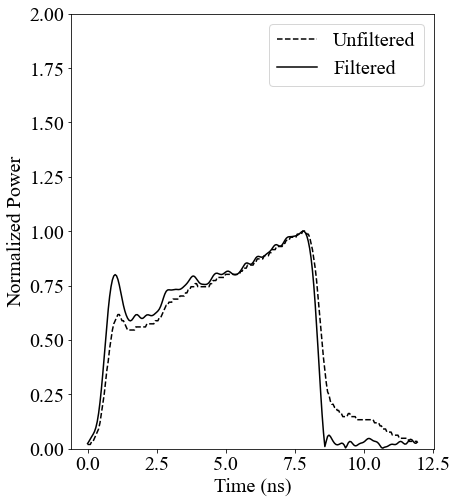

In [993]:
#Deconvolving 25mm Amp
dayData = ConcatenateDayData(yfeOUT, IRfirstampOUT, IR4ampOUT, GREEN4ampOUT, GREENsumOUT)
tensor = SortDayData(dayData)
firstAmp = tensor[6][0][1][1]

total_steps = len(firstAmp)

deconv_firstAmp_arr = [200000000000, 7.4, 1.25, 0.00003]
x_axis, IR, freq_bin, TF = createIRAndTF(total_steps, deconv_firstAmp_arr)

low_pass_filter = 3e9
deconv_firstAmp = deconvolve(firstAmp, TF, low_pass_filter)

start_time = 4.5e-9
stop_time = 16.5e-9

x_axis_spliced, firstAmp_spliced, deconv_firstAmp_spliced = prepareAmpData(firstAmp, deconv_firstAmp, start_time, stop_time)

plt.plot(x_axis_spliced, firstAmp_spliced/max(deconv_firstAmp_spliced), '--', color = "black", label = "Unfiltered")
plt.plot(x_axis_spliced, deconv_firstAmp_spliced/max(deconv_firstAmp_spliced), color = "black" ,label = "Filtered")

plt.xlabel("Time (ns)")
plt.ylabel("Normalized Power")
plt.ylim(0,2)
plt.legend()

### Running Functions

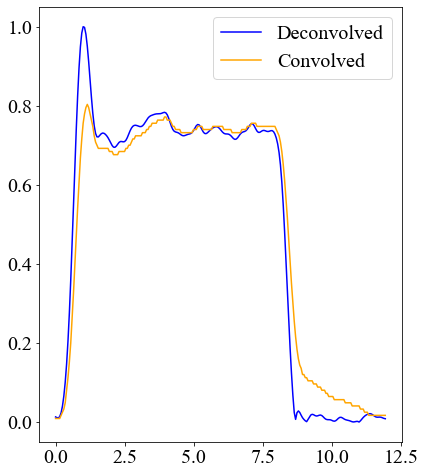

In [988]:
#Deconvolving Second Amp
dayData = ConcatenateDayData(yfeOUT, IRfirstampOUT, IR4ampOUT, GREEN4ampOUT, GREENsumOUT)
tensor = SortDayData(dayData)
secondAmp = tensor[6][2][2][1]

deconv_secondAmp_Arr = [42000000000000, 3800, 1.7, 0]
total_steps = len(secondAmp)
x_axis, IR, freq_bin, TF = createIRAndTF(total_steps, deconv_secondAmp_Arr)

deconv_secondAmp = deconvolve(secondAmp, TF, 3e9)

start_time = 4.5e-9
stop_time = 16.5e-9

x_axis_spliced, secondAmp_spliced, deconv_secondAmp_spliced = prepareAmpData(secondAmp, deconv_secondAmp, start_time, stop_time)

plt.plot(x_axis_spliced, deconv_secondAmp_spliced/max(deconv_secondAmp_spliced), color = "blue", label = "Deconvolved")
plt.plot(x_axis_spliced, secondAmp_spliced/max(deconv_secondAmp_spliced), color = "orange", label = "Convolved")

plt.legend()

### Plotting YFE Convolved and Deconvolved

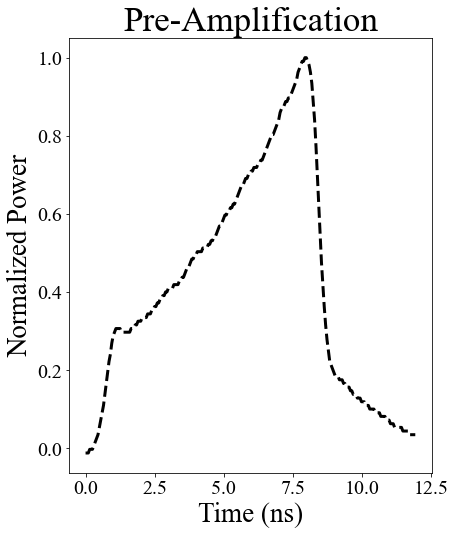

In [961]:
#Plot Convolved

#Deconvolving YFE Signal and Testing Splicing Function
dayData = ConcatenateDayData(yfeOUT, IRfirstampOUT, IR4ampOUT, GREEN4ampOUT, GREENsumOUT)
tensor = SortDayData(dayData)
yfe = tensor[6][0][0][1]

deconv_YFE_Arr = [200000000000, 7.4, 1.27, 0]
total_steps = len(yfe)
x_axis, IR, freq_bin, TF = createIRAndTF(total_steps, deconv_YFE_Arr)

deconv_yfe = deconvolve(yfe, TF, 3e9)

start_time = 4.5e-9
stop_time = 16.5e-9

x_axis_spliced, yfe_spliced, deconv_yfe_spliced = prepareAmpData(yfe, deconv_yfe, start_time, stop_time)

plt.ylabel("Normalized Power", fontsize = 27)
plt.xlabel("Time (ns)", fontsize = 27)
plt.title("Pre-Amplification", fontsize = 35)

plt.plot(x_axis_spliced, yfe_spliced/max(yfe_spliced), '--', color = "black", linewidth = 3)

### Running Functions 3

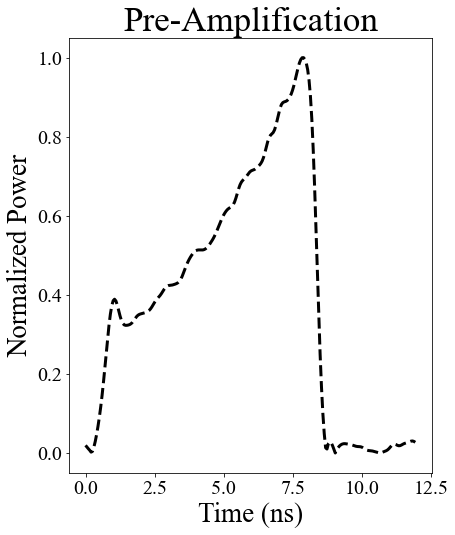

In [962]:
#Plot Convolved

#Deconvolving YFE Signal and Testing Splicing Function
dayData = ConcatenateDayData(yfeOUT, IRfirstampOUT, IR4ampOUT, GREEN4ampOUT, GREENsumOUT)
tensor = SortDayData(dayData)
yfe = tensor[6][0][0][1]

deconv_YFE_Arr = [200000000000, 7.4, 1.27, 0]
total_steps = len(yfe)
x_axis, IR, freq_bin, TF = createIRAndTF(total_steps, deconv_YFE_Arr)

deconv_yfe = deconvolve(yfe, TF, 3e9)

start_time = 4.5e-9
stop_time = 16.5e-9

x_axis_spliced, yfe_spliced, deconv_yfe_spliced = prepareAmpData(yfe, deconv_yfe, start_time, stop_time)

plt.ylabel("Normalized Power", fontsize = 27)
plt.xlabel("Time (ns)", fontsize = 27)

plt.title("Front End")

plt.title("Pre-Amplification", fontsize = 35)

plt.plot(x_axis_spliced, deconv_yfe_spliced/max(deconv_yfe_spliced), '--', color = "black", linewidth = 3)

Error: 0.43551535984799167


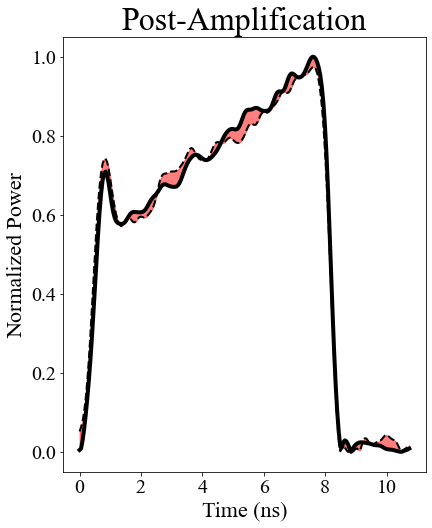

In [996]:
#Comparing First Amp Simulation to Deconvolved First Amp
dayData = ConcatenateDayData(yfeOUT, IRfirstampOUT, IR4ampOUT, GREEN4ampOUT, GREENsumOUT)
tensor = SortDayData(dayData)
yfe = tensor[6][0][0][1]
firstAmp = tensor[6][0][1][1]

total_steps = len(yfe)

#Deconvolve YFE
deconv_YFE_Arr = [200000000000, 7.4, 1.27, 0]
x_axis_yfe, IR_yfe, freq_bin_yfe, TF_yfe = createIRAndTF(total_steps, deconv_YFE_Arr)
deconv_yfe = deconvolve(yfe, TF_yfe, 3e9)

#Deconvolve First Amp
deconv_firstAmp_arr = [350000000000, 7.4, 1.2, 0]
x_axis_firstAmp, IR_firstAmp, freq_bin_firstAmp, TF_firstAmp = createIRAndTF(total_steps, deconv_firstAmp_arr)
deconv_firstAmp = deconvolve(firstAmp, TF_firstAmp, 3e9)

#Prepare Amp Data
start_time = 4.7e-9
stop_time = 15.5e-9
x_axis_yfe, yfe_spliced, deconv_yfe_spliced = prepareAmpData(yfe, deconv_yfe, start_time, stop_time)
x_axis_firstAmp, firstAmp_spliced, deconv_firstAmp_spliced = prepareAmpData(firstAmp, deconv_firstAmp, start_time, stop_time)

pulseEnergy = .128 #Joules
steps = len(deconv_yfe_spliced)
sim_firstAmp, firstAmp_signal_pile, firstAmp_pulse_energy = FirstAmp(deconv_yfe_spliced, pulseEnergy, steps)

plotSimAndRealDeconvolved(x_axis_firstAmp, deconv_firstAmp_spliced, sim_firstAmp)

### Running Functions 4

124.92197141350849
124.92197141350852
3.9373820107657345 % Error


<ipython-input-918-1c4ec6f9eaf7>:44: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  df2.show()


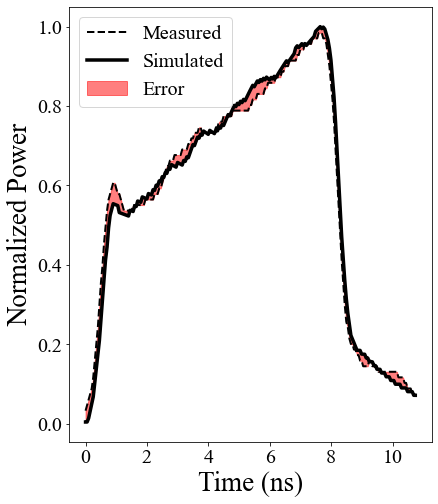

In [945]:
#Comparing First Amp Simulation to Deconvolved First Amp
dayData = ConcatenateDayData(yfeOUT, IRfirstampOUT, IR4ampOUT, GREEN4ampOUT, GREENsumOUT)
tensor = SortDayData(dayData)
yfe = tensor[6][0][0][1]
firstAmp = tensor[6][0][1][1]

#Prepare Amp Data
start_time = 4.7e-9
stop_time = 15.5e-9
x_axis_yfe, yfe_spliced, deconv_yfe_spliced = prepareAmpData(yfe, deconv_yfe, start_time, stop_time)
x_axis_firstAmp, firstAmp_spliced, deconv_firstAmp_spliced = prepareAmpData(firstAmp, deconv_firstAmp, start_time, stop_time)

initial_pulse_energy = .128 #Joules
steps = len(yfe_spliced)
sim_firstAmp, firstAmp_signal_pile, firstAmp_pulse_energy = FirstAmp(yfe_spliced, initial_pulse_energy, steps)

plotSimAndRealConvolved(x_axis_firstAmp, firstAmp_spliced, sim_firstAmp)

### Running Functions 5

149.06623353185344
149.06623353185347
Error: 0.07195607400436368


<ipython-input-1001-f84cfd73c64c>:51: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  df2.show()


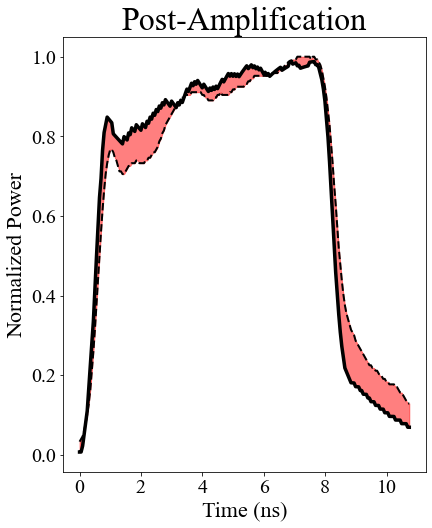

In [1002]:
#Amplifying Simulated Convolved First Amp to Simulated Convolved Second Amp

dayData = ConcatenateDayData(yfeOUT, IRfirstampOUT, IR4ampOUT, GREEN4ampOUT, GREENsumOUT)
tensor = SortDayData(dayData)

yfe = tensor[6][0][0][1]
firstAmp = tensor[6][0][1][1]
secondAmp = tensor[6][3][2][1]

steps_yfe = len(yfe)

#Deconvolve YFE
deconv_YFE_Arr = [200000000000, 7.4, 1.3, 0]
x_axis_yfe, IR_yfe, freq_bin_yfe, TF_yfe = createIRAndTF(steps_yfe, deconv_YFE_Arr)
deconv_yfe = deconvolve(yfe, TF_yfe, 3e9)

#Deconvolve First Amp
deconv_firstAmp_arr = [200000000000, 7.4, 1.25, 0.00003]
x_axis_firstAmp, IR_firstAmp, freq_bin_firstAmp, TF_firstAmp = createIRAndTF(total_steps, deconv_firstAmp_arr)
deconv_firstAmp = deconvolve(firstAmp, TF_firstAmp, 3e9)

#Deconvolve Second Amp
deconv_secondAmp_Arr = [42000000000000, 3400, 1.7, 0]
total_steps = len(secondAmp)
x_axis_secondAmp, IR_secondAmp, freq_bin_secondAmp, TF_secondAmp = createIRAndTF(total_steps, deconv_secondAmp_Arr)
deconv_secondAmp = deconvolve(secondAmp, TF_secondAmp, 3e9)

#Prepare Amp Data
start_time = 4.7e-9
stop_time = 15.5e-9
x_axis_yfe, yfe_spliced, deconv_yfe_spliced = prepareAmpData(yfe, deconv_yfe, start_time, stop_time)
x_axis_firstAmp, firstAmp_spliced, deconv_firstAmp_spliced = prepareAmpData(firstAmp, deconv_firstAmp, start_time, stop_time)
x_axis_secondAmp, secondAmp_spliced, deconv_secondAmp_spliced = prepareAmpData(secondAmp, deconv_secondAmp, start_time, stop_time)

#First Amplification
initial_pulse_energy = .105 #Joules
steps = len(yfe_spliced)
sim_firstAmp, firstAmp_signal_pile, firstAmp_pulse_energy = FirstAmp(yfe_spliced, initial_pulse_energy, steps)

#Second Amplification
steps = len(firstAmp_spliced)
sim_secondAmp, secondAmp_pulse_energy = SecondAmp(sim_firstAmp, firstAmp_signal_pile, firstAmp_pulse_energy, steps)

plotSimAndRealConvolved(x_axis_secondAmp, secondAmp_spliced, sim_secondAmp)

### Running Functions 6

Error: 0.02754568972512592


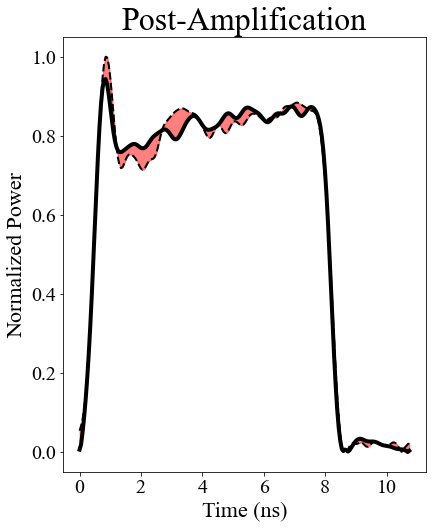

In [1003]:
#Amplifying Simulated Deconvolved First Amp to Simulated deconvolved Second Amp
dayData = ConcatenateDayData(yfeOUT, IRfirstampOUT, IR4ampOUT, GREEN4ampOUT, GREENsumOUT)
tensor = SortDayData(dayData)

yfe = tensor[6][0][0][1]
firstAmp = tensor[6][0][1][1]
secondAmp = tensor[6][3][2][1]

#Deconvolve YFE
deconv_YFE_Arr = [200000000000, 7.4, 1.3, 0]
x_axis_yfe, IR_yfe, freq_bin_yfe, TF_yfe = createIRAndTF(total_steps, deconv_YFE_Arr)
deconv_yfe = deconvolve(yfe, TF_yfe, 2e9)

#Deconvolve First Amp
deconv_firstAmp_arr = [200000000000, 7.4, 1.25, 0.00003]
x_axis_firstAmp, IR_firstAmp, freq_bin_firstAmp, TF_firstAmp = createIRAndTF(total_steps, deconv_firstAmp_arr)
deconv_firstAmp = deconvolve(firstAmp, TF_firstAmp, 3e9)

#Deconvolve Second Amp
deconv_secondAmp_Arr = [200000000000000, 15000, 1.3, 0]#[42000000000000, 3400, 1.7, 0]
total_steps = len(secondAmp)
x_axis_secondAmp, IR_secondAmp, freq_bin_secondAmp, TF_secondAmp = createIRAndTF(total_steps, deconv_secondAmp_Arr)
deconv_secondAmp = deconvolve(secondAmp, TF_secondAmp, 3e9)

#Prepare Amp Data
start_time = 4.7e-9
stop_time = 15.5e-9
x_axis_yfe, yfe_spliced, deconv_yfe_spliced = prepareAmpData(yfe, deconv_yfe, start_time, stop_time)
x_axis_firstAmp, firstAmp_spliced, deconv_firstAmp_spliced = prepareAmpData(firstAmp, deconv_firstAmp, start_time, stop_time)
x_axis_secondAmp, secondAmp_spliced, deconv_secondAmp_spliced = prepareAmpData(secondAmp, deconv_secondAmp, start_time, stop_time)

#First Amplification
initial_pulse_energy = .105
#Joules
steps = len(yfe_spliced)
sim_firstAmp, firstAmp_signal_pile, firstAmp_pulse_energy = FirstAmp(deconv_yfe_spliced, initial_pulse_energy, steps)

#Second Amplification
steps = len(firstAmp_spliced)
sim_secondAmp_deconv, secondAmp_pulse_energy = SecondAmp(sim_firstAmp, firstAmp_signal_pile, firstAmp_pulse_energy, steps)

plotSimAndRealDeconvolved(x_axis_secondAmp, deconv_secondAmp_spliced, sim_secondAmp_deconv)